***
# __Imports__
***

In [1]:
from statistics import mean

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.model_selection import KFold, cross_val_predict, cross_validate, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from aqmd_pylib.aqmd_lib import data_toolkit as dtk
from aqmd_pylib.aqmd_lib.util import nLoop
from aqmd_pylib.aqmd_lib import util

***
# __Settings__
***

In [2]:
RANDOM_STATE = 42
SAVE_FIGURES = True
SAVE_TABLES = True
USE_SCALED = False
PARALLEL_CORES = -1  # "-1" will use all cores available

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

***
# __Load Data__
***

In [3]:
iowa_pm25 = pd.read_csv('../data/complete_sets/iowa/iowa_full_pm25.csv')
iowa_pm25

datetime-America/Los_Angeles  Iowa PM2.5 [ug/m3]  year  month  day  \
0       2021-05-21 12:30:00-07:00           10.098479  2021      5   21   
1       2021-05-21 12:45:00-07:00           10.037741  2021      5   21   
2       2021-05-21 13:00:00-07:00            9.977003  2021      5   21   
3       2021-05-21 13:15:00-07:00            9.916265  2021      5   21   
4       2021-05-21 13:30:00-07:00            9.943220  2021      5   21   
...                           ...                 ...   ...    ...  ...   
2986    2021-06-27 21:30:00-07:00            5.343054  2021      6   27   
2987    2021-06-27 22:00:00-07:00            5.339244  2021      6   27   
2988    2021-06-27 22:30:00-07:00            5.335434  2021      6   27   
2989    2021-06-27 23:00:00-07:00            5.331624  2021      6   27   
2990    2021-06-27 23:30:00-07:00            5.327814  2021      6   27   

      dayofweek_Sunday  dayofweek_Monday  dayofweek_Tuesday  \
0                    0                 0                  0   
1                    0                 0                  0   
2                    0                 0                  0   
3                    0                 0                  0   
4                    0                 0                  0   
...                ...               ...                ...   
2986                 1                 0                  0   
2987                 1                 0                  0   
2988                 1                 0                  0   
2989                 1                 0                  0   
2990                 1                 0                  0   

      dayofweek_Wednesday  dayofweek_Thursday  dayofweek_Friday  \
0                       0                   0                 1   
1                       0                   0                 1   
2                       0                   0                 1   
3                       0                   0                 1   
4                       0                   0                 1   
...                   ...                 ...               ...   
2986                    0                   0                 0   
2987                    0                   0                 0   
2988                    0                   0                 0   
2989                    0                   0                 0   
2990                    0                   0                 0   

      dayofweek_Saturday   temp  pressure  humidity  wind_speed  wind_deg  \
0                      0  19.91      1015        30        2.68       260   
1                      0  19.91      1015        30        2.68       260   
2                      0  21.14      1014        26        3.13       306   
3                      0  21.14      1014        26        3.13       306   
4                      0  21.14      1014        26        3.13       306   
...                  ...    ...       ...       ...         ...       ...   
2986                   0  25.48      1005        60        0.89       181   
2987                   0  24.69      1006        62        1.34       233   
2988                   0  24.69      1006        62        1.34       233   
2989                   0  23.93      1006        64        0.89       229   
2990                   0  23.93      1006        64        0.89       229   

      PM2.5 Background [ug/m3]  Density Local 1 (#Vehicles/mile)  \
0                         -1.0                         42.761836   
1                         -1.0                         36.143933   
2                          3.0                         37.388800   
3                          3.0                         36.866897   
4                          3.0                         35.844480   
...                        ...                               ...   
2986                      11.0                         17.637760   
2987                      11.0                         12.801600   
2988 

In [4]:
iowa_pm25 = dtk.df_str2dt(iowa_pm25, 'datetime-America/Los_Angeles',
                          '%Y-%m-%d %H:%M:%S%z', curr_tz='America/Los_Angeles', overwrite=True)
iowa_pm25.set_index('datetime-America/Los_Angeles', inplace=True)
iowa_pm25.info()
iowa_pm25

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2991 entries, 2021-05-21 12:30:00-07:00 to 2021-06-27 23:30:00-07:00
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Iowa PM2.5 [ug/m3]                 2991 non-null   float64
 1   year                               2991 non-null   int64  
 2   month                              2991 non-null   int64  
 3   day                                2991 non-null   int64  
 4   dayofweek_Sunday                   2991 non-null   int64  
 5   dayofweek_Monday                   2991 non-null   int64  
 6   dayofweek_Tuesday                  2991 non-null   int64  
 7   dayofweek_Wednesday                2991 non-null   int64  
 8   dayofweek_Thursday                 2991 non-null   int64  
 9   dayofweek_Friday                   2991 non-null   int64  
 10  dayofweek_Saturday                 2991 non-null   int64  
 11  temp    

Iowa PM2.5 [ug/m3]  year  month  day  \
datetime-America/Los_Angeles                                         
2021-05-21 12:30:00-07:00              10.098479  2021      5   21   
2021-05-21 12:45:00-07:00              10.037741  2021      5   21   
2021-05-21 13:00:00-07:00               9.977003  2021      5   21   
2021-05-21 13:15:00-07:00               9.916265  2021      5   21   
2021-05-21 13:30:00-07:00               9.943220  2021      5   21   
...                                          ...   ...    ...  ...   
2021-06-27 21:30:00-07:00               5.343054  2021      6   27   
2021-06-27 22:00:00-07:00               5.339244  2021      6   27   
2021-06-27 22:30:00-07:00               5.335434  2021      6   27   
2021-06-27 23:00:00-07:00               5.331624  2021      6   27   
2021-06-27 23:30:00-07:00               5.327814  2021      6   27   

                              dayofweek_Sunday  dayofweek_Monday  \
datetime-America/Los_Angeles                                       
2021-05-21 12:30:00-07:00                    0                 0   
2021-05-21 12:45:00-07:00                    0                 0   
2021-05-21 13:00:00-07:00                    0                 0   
2021-05-21 13:15:00-07:00                    0                 0   
2021-05-21 13:30:00-07:00                    0                 0   
...                                        ...               ...   
2021-06-27 21:30:00-07:00                    1                 0   
2021-06-27 22:00:00-07:00                    1                 0   
2021-06-27 22:30:00-07:00                    1                 0   
2021-06-27 23:00:00-07:00                    1                 0   
2021-06-27 23:30:00-07:00                    1                 0   

                              dayofweek_Tuesday  dayofweek_Wednesday  \
datetime-America/Los_Angeles                                           
2021-05-21 12:30:00-07:00                     0                    0   
2021-05-21 12:45:00-07:00                     0                    0   
2021-05-21 13:00:00-07:00                     0                    0   
2021-05-21 13:15:00-07:00                     0                    0   
2021-05-21 13:30:00-07:00                     0                    0   
...                                         ...                  ...   
2021-06-27 21:30:00-07:00                     0                    0   
2021-06-27 22:00:00-07:00                     0                    0   
2021-06-27 22:30:00-07:00                     0                    0   
2021-06-27 23:00:00-07:00                     0                    0   
2021-06-27 23:30:00-07:00                     0                    0   

                              dayofweek_Thursday  dayofweek_Friday  \
datetime-America/Los_Angeles                                         
2021-05-21 12:30:00-07:00                      0                 1   
2021-05-21 12:45:00-07:00                      0                 1   
2021-05-21 13:00:00-07:00                      0                 1   
2021-05-21 13:15:00-07:00                      0                 1   
2021-05-21 13:30:00-07:00                      0                 1   
...                                          ...               ...   
2021-06-27 21:30:00-07:00                      0                 0   
2021-06-27 22:00:00-07:00                      0                 0   
2021-06-27 22:30:00-07:00                      0                 0   
2021-06-27 23:00:00-07:00                      0                 0   
2021-06-27 23:30:00-07:00                      0                 0   

                              dayofweek_Saturday   temp  pressure  humidity  \
datetime-America/Los_Angeles                                                  
2021-05-21 12:30:00-07:00                      0  19.91      1015        30   
2021-05-21 12:45:00-07:00                      0  19.91      1015        30   
2021-05-21 13:00:00-07:00                      0  21.14      1014     

In [5]:

continuous_variables = [
    'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg',
    'PM2.5 Background [ug/m3]',
    'Density Local 1 (#Vehicles/mile)',
    'Density Local 2 (#Vehicles/mile)',
    'Density Local 9 (#Vehicles/mile)',
    'Density Local 10 (#Vehicles/mile)',
    'Density Fwy 1 (#Vehicles/mile)',
    'Density Fwy 2 (#Vehicles/mile)',
]
iowa_scaled = iowa_pm25.copy()
for feat in continuous_variables:
    iowa_scaled[feat] = StandardScaler().fit_transform(iowa_scaled.loc[:, [feat]])
iowa_scaled

Iowa PM2.5 [ug/m3]  year  month  day  \
datetime-America/Los_Angeles                                         
2021-05-21 12:30:00-07:00              10.098479  2021      5   21   
2021-05-21 12:45:00-07:00              10.037741  2021      5   21   
2021-05-21 13:00:00-07:00               9.977003  2021      5   21   
2021-05-21 13:15:00-07:00               9.916265  2021      5   21   
2021-05-21 13:30:00-07:00               9.943220  2021      5   21   
...                                          ...   ...    ...  ...   
2021-06-27 21:30:00-07:00               5.343054  2021      6   27   
2021-06-27 22:00:00-07:00               5.339244  2021      6   27   
2021-06-27 22:30:00-07:00               5.335434  2021      6   27   
2021-06-27 23:00:00-07:00               5.331624  2021      6   27   
2021-06-27 23:30:00-07:00               5.327814  2021      6   27   

                              dayofweek_Sunday  dayofweek_Monday  \
datetime-America/Los_Angeles                                       
2021-05-21 12:30:00-07:00                    0                 0   
2021-05-21 12:45:00-07:00                    0                 0   
2021-05-21 13:00:00-07:00                    0                 0   
2021-05-21 13:15:00-07:00                    0                 0   
2021-05-21 13:30:00-07:00                    0                 0   
...                                        ...               ...   
2021-06-27 21:30:00-07:00                    1                 0   
2021-06-27 22:00:00-07:00                    1                 0   
2021-06-27 22:30:00-07:00                    1                 0   
2021-06-27 23:00:00-07:00                    1                 0   
2021-06-27 23:30:00-07:00                    1                 0   

                              dayofweek_Tuesday  dayofweek_Wednesday  \
datetime-America/Los_Angeles                                           
2021-05-21 12:30:00-07:00                     0                    0   
2021-05-21 12:45:00-07:00                     0                    0   
2021-05-21 13:00:00-07:00                     0                    0   
2021-05-21 13:15:00-07:00                     0                    0   
2021-05-21 13:30:00-07:00                     0                    0   
...                                         ...                  ...   
2021-06-27 21:30:00-07:00                     0                    0   
2021-06-27 22:00:00-07:00                     0                    0   
2021-06-27 22:30:00-07:00                     0                    0   
2021-06-27 23:00:00-07:00                     0                    0   
2021-06-27 23:30:00-07:00                     0                    0   

                              dayofweek_Thursday  dayofweek_Friday  \
datetime-America/Los_Angeles                                         
2021-05-21 12:30:00-07:00                      0                 1   
2021-05-21 12:45:00-07:00                      0                 1   
2021-05-21 13:00:00-07:00                      0                 1   
2021-05-21 13:15:00-07:00                      0                 1   
2021-05-21 13:30:00-07:00                      0                 1   
...                                          ...               ...   
2021-06-27 21:30:00-07:00                      0                 0   
2021-06-27 22:00:00-07:00                      0                 0   
2021-06-27 22:30:00-07:00                      0                 0   
2021-06-27 23:00:00-07:00                      0                 0   
2021-06-27 23:30:00-07:00                      0                 0   

                              dayofweek_Saturday      temp  pressure  \
datetime-America/Los_Angeles                                           
2021-05-21 12:30:00-07:00                      0 -0.612280  0.739532   
2021-05-21 12:45:00-07:00                      0 -0.612280  0.739532   
2021-05-21 13:00:00-07:00                      0 -0.433268  0.407559   
2021-05-21 13:15:00-07:00 

In [6]:
if USE_SCALED:
    iowa_x = iowa_scaled.drop(columns='Iowa PM2.5 [ug/m3]')
else:
    iowa_x = iowa_pm25.drop(columns='Iowa PM2.5 [ug/m3]')
iowa_x.info()
iowa_x

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2991 entries, 2021-05-21 12:30:00-07:00 to 2021-06-27 23:30:00-07:00
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   year                               2991 non-null   int64  
 1   month                              2991 non-null   int64  
 2   day                                2991 non-null   int64  
 3   dayofweek_Sunday                   2991 non-null   int64  
 4   dayofweek_Monday                   2991 non-null   int64  
 5   dayofweek_Tuesday                  2991 non-null   int64  
 6   dayofweek_Wednesday                2991 non-null   int64  
 7   dayofweek_Thursday                 2991 non-null   int64  
 8   dayofweek_Friday                   2991 non-null   int64  
 9   dayofweek_Saturday                 2991 non-null   int64  
 10  temp                               2991 non-null   float64
 11  pressure

year  month  day  dayofweek_Sunday  \
datetime-America/Los_Angeles                                       
2021-05-21 12:30:00-07:00     2021      5   21                 0   
2021-05-21 12:45:00-07:00     2021      5   21                 0   
2021-05-21 13:00:00-07:00     2021      5   21                 0   
2021-05-21 13:15:00-07:00     2021      5   21                 0   
2021-05-21 13:30:00-07:00     2021      5   21                 0   
...                            ...    ...  ...               ...   
2021-06-27 21:30:00-07:00     2021      6   27                 1   
2021-06-27 22:00:00-07:00     2021      6   27                 1   
2021-06-27 22:30:00-07:00     2021      6   27                 1   
2021-06-27 23:00:00-07:00     2021      6   27                 1   
2021-06-27 23:30:00-07:00     2021      6   27                 1   

                              dayofweek_Monday  dayofweek_Tuesday  \
datetime-America/Los_Angeles                                        
2021-05-21 12:30:00-07:00                    0                  0   
2021-05-21 12:45:00-07:00                    0                  0   
2021-05-21 13:00:00-07:00                    0                  0   
2021-05-21 13:15:00-07:00                    0                  0   
2021-05-21 13:30:00-07:00                    0                  0   
...                                        ...                ...   
2021-06-27 21:30:00-07:00                    0                  0   
2021-06-27 22:00:00-07:00                    0                  0   
2021-06-27 22:30:00-07:00                    0                  0   
2021-06-27 23:00:00-07:00                    0                  0   
2021-06-27 23:30:00-07:00                    0                  0   

                              dayofweek_Wednesday  dayofweek_Thursday  \
datetime-America/Los_Angeles                                            
2021-05-21 12:30:00-07:00                       0                   0   
2021-05-21 12:45:00-07:00                       0                   0   
2021-05-21 13:00:00-07:00                       0                   0   
2021-05-21 13:15:00-07:00                       0                   0   
2021-05-21 13:30:00-07:00                       0                   0   
...                                           ...                 ...   
2021-06-27 21:30:00-07:00                       0                   0   
2021-06-27 22:00:00-07:00                       0                   0   
2021-06-27 22:30:00-07:00                       0                   0   
2021-06-27 23:00:00-07:00                       0                   0   
2021-06-27 23:30:00-07:00                       0                   0   

                              dayofweek_Friday  dayofweek_Saturday   temp  \
datetime-America/Los_Angeles                                                
2021-05-21 12:30:00-07:00                    1                   0  19.91   
2021-05-21 12:45:00-07:00                    1                   0  19.91   
2021-05-21 13:00:00-07:00                    1                   0  21.14   
2021-05-21 13:15:00-07:00                    1                   0  21.14   
2021-05-21 13:30:00-07:00                    1                   0  21.14   
...                                        ...                 ...    ...   
2021-06-27 21:30:00-07:00                    0                   0  25.48   
2021-06-27 22:00:00-07:00                    0                   0  24.69   
2021-06-27 22:30:00-07:00                    0                   0  24.69   
2021-06-27 23:00:00-07:00                    0                   0  23.93   
2021-06-27 23:30:00-07:00                    0                   0  23.93   

                              pressure  humidity  wind_speed  wind_deg  \
datetime-America/Los_Angeles                                             
2021-05-21 12:30:00-07:00         1015        30        2.68       260   
2021-05-21 12:45:00-07:00         1015        30        2.68       260   

In [7]:
iowa_y = iowa_pm25.loc[:, 'Iowa PM2.5 [ug/m3]']
iowa_y

datetime-America/Los_Angeles
2021-05-21 12:30:00-07:00    10.098479
2021-05-21 12:45:00-07:00    10.037741
2021-05-21 13:00:00-07:00     9.977003
2021-05-21 13:15:00-07:00     9.916265
2021-05-21 13:30:00-07:00     9.943220
                               ...    
2021-06-27 21:30:00-07:00     5.343054
2021-06-27 22:00:00-07:00     5.339244
2021-06-27 22:30:00-07:00     5.335434
2021-06-27 23:00:00-07:00     5.331624
2021-06-27 23:30:00-07:00     5.327814
Name: Iowa PM2.5 [ug/m3], Length: 2991, dtype: float64

In [25]:
iowa_train_x, iowa_test_x, iowa_train_y, iowa_test_y = train_test_split(
    iowa_x, iowa_y,
    test_size=0.2,
    random_state=RANDOM_STATE
)
if SAVE_TABLES:
    iowa_train_x.to_csv('../data/complete_sets/iowa/iowa_train_x.csv')
    iowa_test_x.to_csv('../data/complete_sets/iowa/iowa_test_x.csv')
    iowa_train_y.to_csv('../data/complete_sets/iowa/iowa_train_y.csv')
    iowa_test_y.to_csv('../data/complete_sets/iowa/iowa_test_y.csv')

NameError: name 'SAVE_TABLES' is not defined

***
# __Gradient Boosted Regression Model__
***

***
> ## __Model Parameters__
***

In [9]:
gbt_model_params = {
    'loss'                    : 'huber',
    'learning_rate'           : 0.001,
    'verbose'                 : True,
    'n_estimators'            : 9000,
    'subsample'               : 1.0,
    'criterion'               : 'friedman_mse',
    'min_samples_split'       : 2,
    'min_samples_leaf'        : 2,
    'min_weight_fraction_leaf': 0.0,
    'max_depth'               : 4,
    'min_impurity_decrease'   : 0.0,
    'init'                    : None,
    'random_state'            : RANDOM_STATE,
    'max_features'            : 'auto',
    'alpha'                   : 0.9,
    'max_leaf_nodes'          : None,
    'warm_start'              : False,
    'validation_fraction'     : 0.1,
    'n_iter_no_change'        : 100

}

***
> ## __Cross Validation - Model Evaluation__
***

In [10]:
gbt_model_cv = GradientBoostingRegressor(**gbt_model_params)
cv_split = KFold(
    n_splits=5,
    shuffle=True,
    random_state=RANDOM_STATE
)
cv_results = cross_validate(gbt_model_cv,
                            X=iowa_x,
                            y=iowa_y,
                            n_jobs=PARALLEL_CORES,
                            cv=cv_split,
                            scoring=(
                            'r2', 'explained_variance', 'neg_mean_squared_error', 'neg_root_mean_squared_error'),
                            return_train_score=True,
                            verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.3min remaining:  5.0min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.4min finished


In [11]:
print(
    f'\nCross Validation Results:\n'
    f'  Fit Time: {mean(cv_results["fit_time"])}\n'
    f'  Score Time: {mean(cv_results["score_time"])}\n'
    f'  Test R2: {mean(cv_results["test_r2"])}\n'
    f'  Train R2: {mean(cv_results["train_r2"])}\n'
    f'  Test MSE: {abs(mean(cv_results["test_neg_mean_squared_error"]))}\n'
    f'  Train MSE: {abs(mean(cv_results["train_neg_mean_squared_error"]))}\n'
    f'  Test RMSE: {abs(mean(cv_results["test_neg_root_mean_squared_error"]))}\n'
    f'  Train RMSE: {abs(mean(cv_results["train_neg_root_mean_squared_error"]))}\n'
    f'  Test Explained Variance: {mean(cv_results["test_explained_variance"])}\n'
    f'  Train Explained Variance: {mean(cv_results["train_explained_variance"])}\n'
)


Cross Validation Results:
  Fit Time: 198.3438660621643
  Score Time: 0.1105926513671875
  Test R2: 0.9159959422274153
  Train R2: 0.9402462472790394
  Test MSE: 1.976627099145527
  Train MSE: 1.4073646811826306
  Test RMSE: 1.4024206577402476
  Train RMSE: 1.1861385524835266
  Test Explained Variance: 0.9163913438505443
  Train Explained Variance: 0.9404122099038053



In [12]:
gbt_model_cvp = GradientBoostingRegressor(**gbt_model_params)

In [13]:
cv_y = cross_val_predict(gbt_model_cvp,
                         X=iowa_x,
                         y=iowa_y,
                         cv=cv_split,
                         n_jobs=PARALLEL_CORES,
                         verbose=True)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:  3.6min remaining:  5.3min
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:  3.6min finished


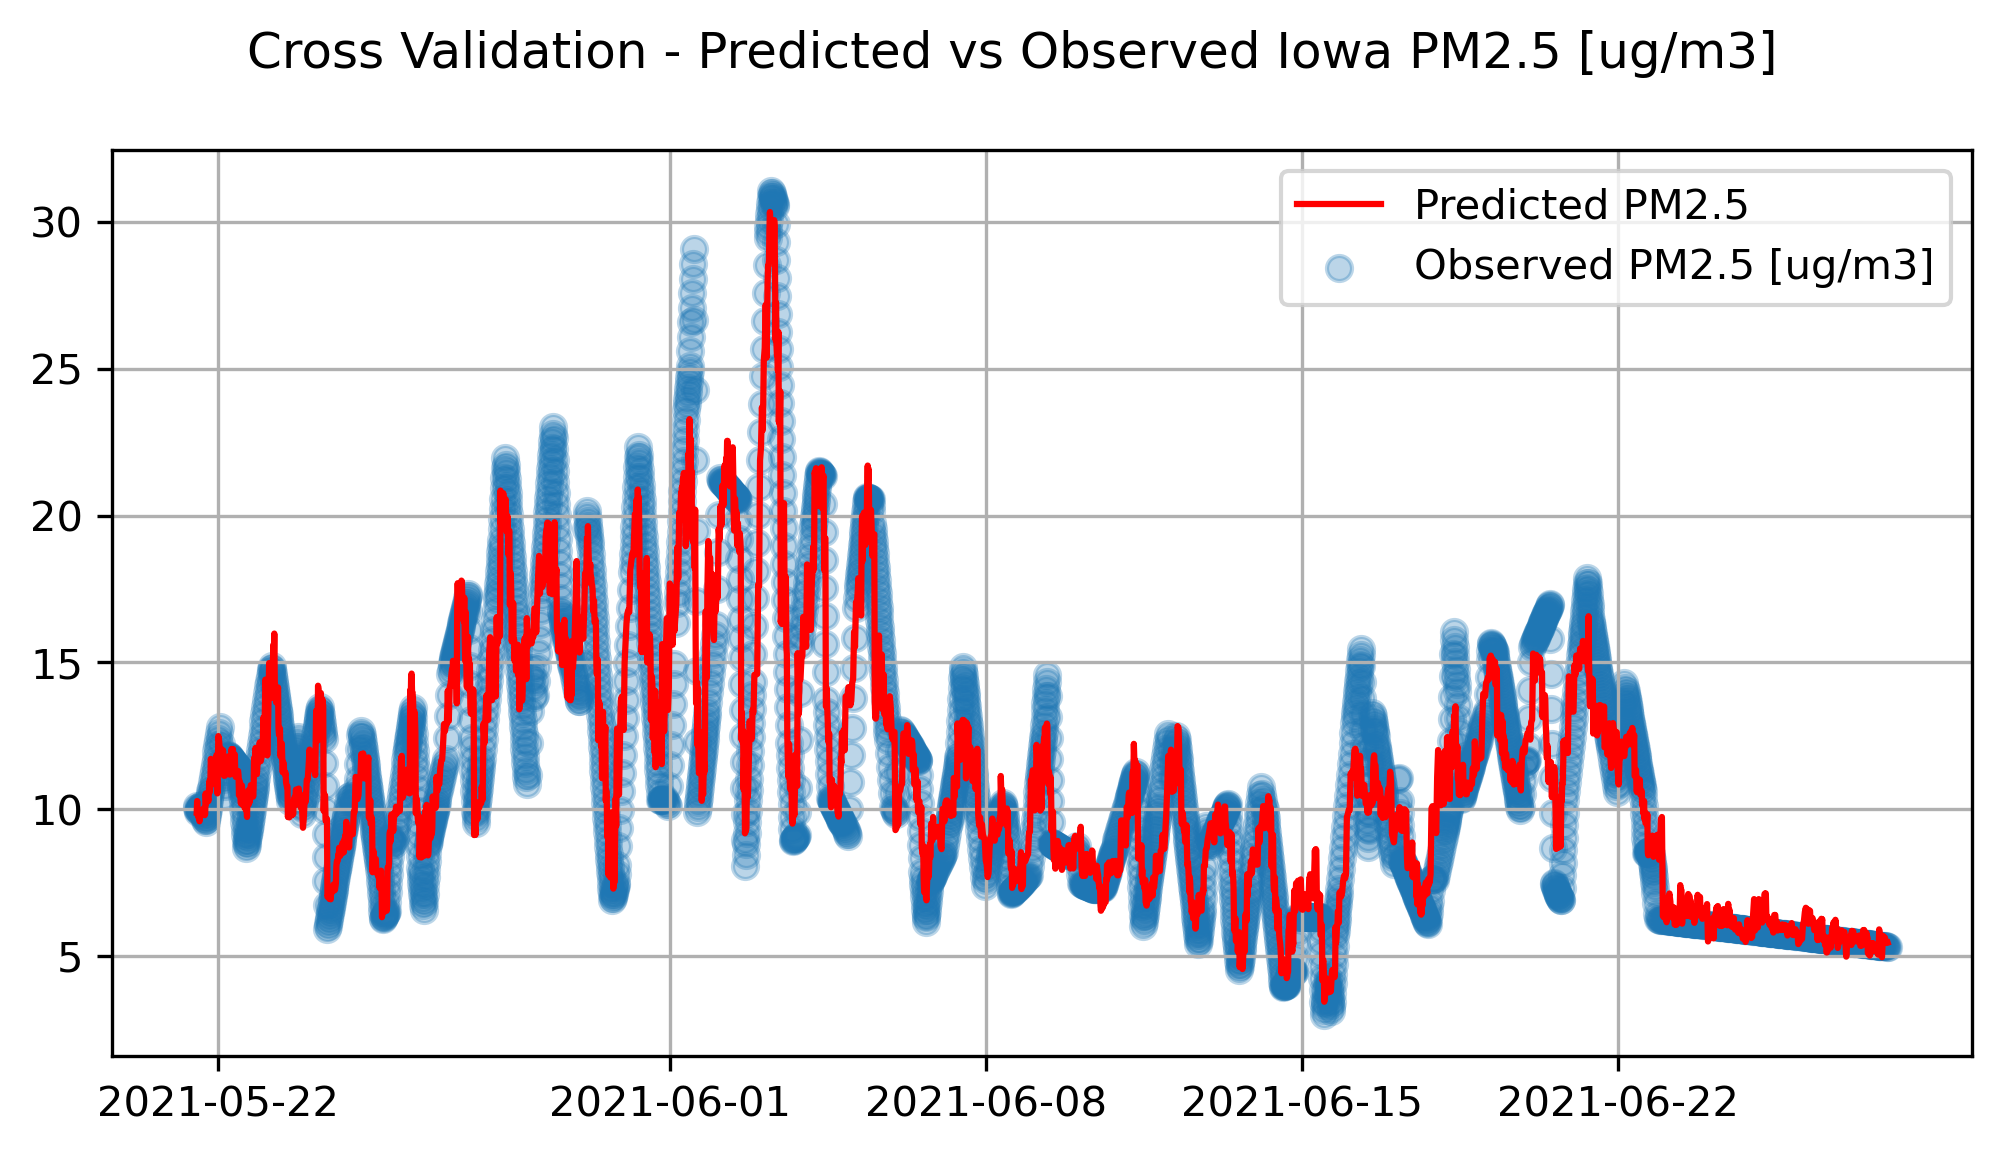

In [14]:
cv_fig, cv_ax = plt.subplots(dpi=300, figsize=(8, 4))
cv_iowa = pd.concat([iowa_x, iowa_y], axis=1)
cv_iowa['Predicted Iowa PM2.5 [ug/m3]'] = cv_y
cv_iowa.sort_index(inplace=True)
cv_iowa.reset_index(inplace=True)
cv_ax.scatter(
    cv_iowa.loc[:, 'datetime-America/Los_Angeles'],
    cv_iowa.loc[:, 'Iowa PM2.5 [ug/m3]'],
    label='Observed PM2.5 [ug/m3]',
    alpha=0.3
)
cv_ax.plot(
    cv_iowa.loc[:, 'datetime-America/Los_Angeles'],
    cv_iowa.loc[:, 'Predicted Iowa PM2.5 [ug/m3]'],
    label='Predicted PM2.5',
    color='red'
)
cv_fig.suptitle('Cross Validation - Predicted vs Observed Iowa PM2.5 [ug/m3]')
cv_ax.legend()
cv_ax.grid()
if SAVE_FIGURES:
    cv_fig.savefig('../graphs/traffic_density/cross_validation_pm25.png', dpi=300)

***
> ## __Leave One Out - Model Evaluation__
***

In [15]:
gbt_model_loo = GradientBoostingRegressor(**gbt_model_params)
gbt_model_loo.fit(X=iowa_train_x.values, y=iowa_train_y)
iowa_test_predY = gbt_model_loo.predict(iowa_test_x.values)

      Iter       Train Loss   Remaining Time 
         1          11.0906            3.60m
         2          11.0746            3.90m
         3          11.0586            4.00m
         4          11.0427            3.94m
         5          11.0268            3.78m
         6          11.0110            3.80m
         7          10.9952            3.75m
         8          10.9794            3.75m
         9          10.9636            3.75m
        10          10.9479            3.79m
        20          10.7905            3.91m
        30          10.6379            3.70m
        40          10.4949            3.58m
        50          10.3512            3.54m
        60          10.2215            3.43m
        70          10.0891            3.30m
        80           9.9578            3.28m
        90           9.8273            3.19m
       100           9.6988            3.12m
       200           8.5698            2.61m
       300           7.6220            2.72m
       40

In [16]:
iowa_test = pd.concat([iowa_test_x, iowa_test_y], axis=1)
iowa_test['pred Iowa PM2.5 [ug/m3]'] = iowa_test_predY
iowa_test.sort_index(inplace=True)
iowa_test.reset_index(inplace=True)
iowa_test.info()
iowa_test

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 599 entries, 0 to 598
Data columns (total 25 columns):
 #   Column                             Non-Null Count  Dtype                                 
---  ------                             --------------  -----                                 
 0   datetime-America/Los_Angeles       599 non-null    datetime64[ns, pytz.FixedOffset(-420)]
 1   year                               599 non-null    int64                                 
 2   month                              599 non-null    int64                                 
 3   day                                599 non-null    int64                                 
 4   dayofweek_Sunday                   599 non-null    int64                                 
 5   dayofweek_Monday                   599 non-null    int64                                 
 6   dayofweek_Tuesday                  599 non-null    int64                                 
 7   dayofweek_Wednesday                

datetime-America/Los_Angeles  year  month  day  dayofweek_Sunday  \
0      2021-05-21 12:30:00-07:00  2021      5   21                 0   
1      2021-05-21 14:15:00-07:00  2021      5   21                 0   
2      2021-05-21 16:00:00-07:00  2021      5   21                 0   
3      2021-05-21 19:45:00-07:00  2021      5   21                 0   
4      2021-05-21 20:00:00-07:00  2021      5   21                 0   
..                           ...   ...    ...  ...               ...   
594    2021-06-27 17:15:00-07:00  2021      6   27                 1   
595    2021-06-27 17:30:00-07:00  2021      6   27                 1   
596    2021-06-27 17:45:00-07:00  2021      6   27                 1   
597    2021-06-27 19:45:00-07:00  2021      6   27                 1   
598    2021-06-27 22:00:00-07:00  2021      6   27                 1   

     dayofweek_Monday  dayofweek_Tuesday  dayofweek_Wednesday  \
0                   0                  0                    0   
1                   0                  0                    0   
2                   0                  0                    0   
3                   0                  0                    0   
4                   0                  0                    0   
..                ...                ...                  ...   
594                 0                  0                    0   
595                 0                  0                    0   
596                 0                  0                    0   
597                 0                  0                    0   
598                 0                  0                    0   

     dayofweek_Thursday  dayofweek_Friday  dayofweek_Saturday   temp  \
0                     0                 1                   0  19.91   
1                     0                 1                   0  21.65   
2                     0                 1                   0  21.84   
3                     0                 1                   0  17.43   
4                     0                 1                   0  15.76   
..                  ...               ...                 ...    ...   
594                   0                 0                   0  33.84   
595                   0                 0                   0  33.84   
596                   0                 0                   0  33.84   
597                   0                 0                   0  30.81   
598                   0                 0                   0  24.69   

     pressure  humidity  wind_speed  wind_deg  PM2.5 Background [ug/m3]  \
0        1015        30        2.68       260                      -1.0   
1        1014        27        3.58       179                       5.0   
2        1013        29        3.58       190                       1.0   
3        1014        45        3.13       284                       6.0   
4        1016        54        1.79       261                       5.0   
..        ...       ...         ...       ...                       ...   
594      1004        40        2.24       171                      11.0   
595      1004        40        2.24       171                      11.0   
596      1004        40        2.24       171                      11.0   
597      1005        45        1.79       281                      11.0   
598      1006        62        1.34       233                      11.0   

     Density Local 1 (#Vehicles/mile)  Density Local 2 (#Vehicles/mile)  \
0                           42.761836                         32.168858   
1                           32.871343                         30.999446   
2                           27.399916                         31.958604   
3                           34.924733                         27.072702   
4                           35.174989                         30.166439   
..                                ...                               ...   
594                         21.635453                         23.82

In [17]:
print(
    f'\nLeave One Out Results:\n'
    f'  R2: {metrics.r2_score(iowa_test_y, iowa_test_predY)}\n'
    f'  MSE:{metrics.mean_squared_error(iowa_test_y, iowa_test_predY, squared=True)}\n'
    f'  RMSE: {metrics.mean_squared_error(iowa_test_y, iowa_test_predY, squared=False)}\n'
    f'  Explained Variance {metrics.explained_variance_score(iowa_test_y, iowa_test_predY)}\n'
)


Leave One Out Results:
  R2: 0.908083459228021
  MSE:2.1046769937524252
  RMSE: 1.4507504932800903
  Explained Variance 0.9081730099078271



C:\Users\Alex\anaconda3\lib\site-packages\sklearn\base.py:438: UserWarning: X has feature names, but GradientBoostingRegressor was fitted without feature names
  warnings.warn(


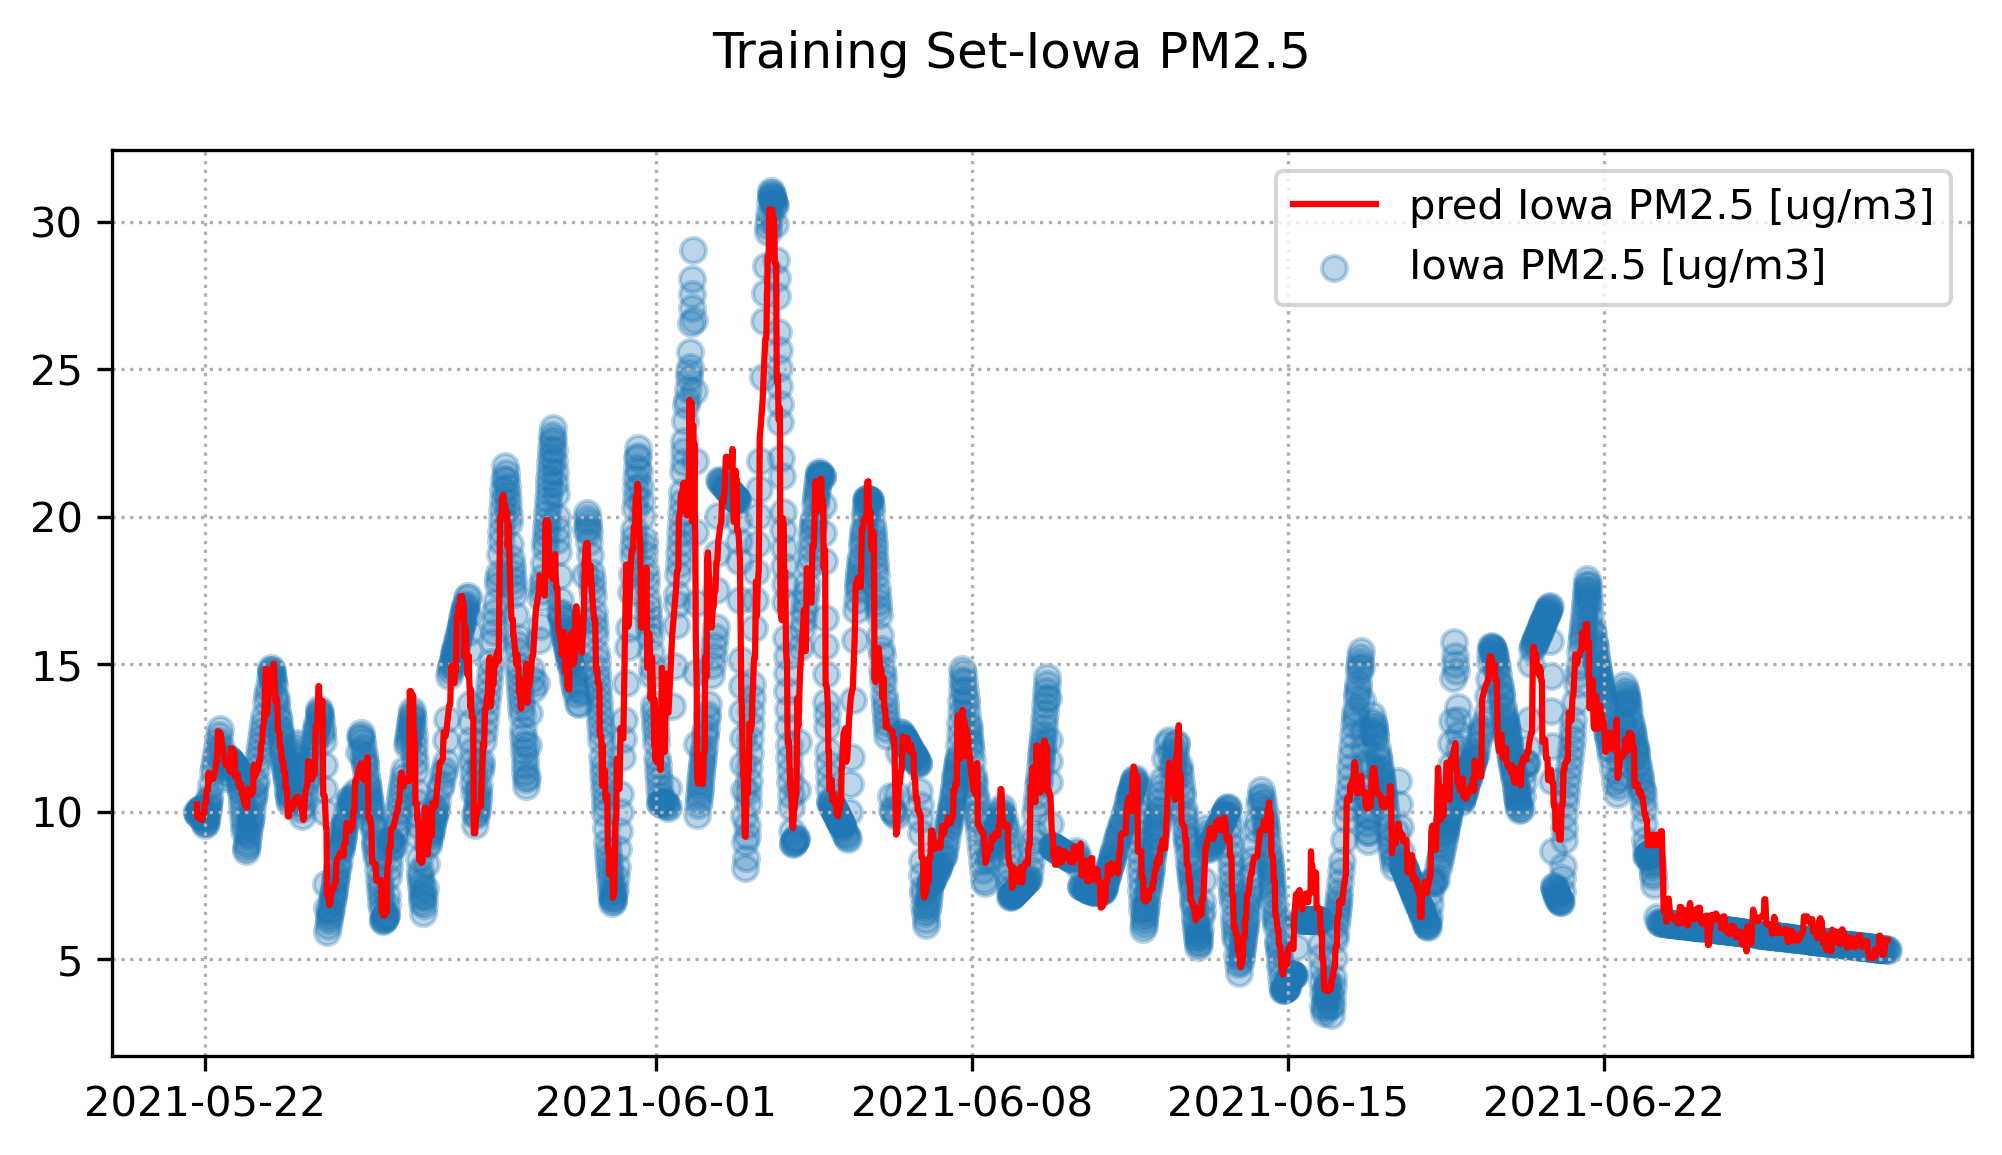

In [18]:
train_fig, train_ax = plt.subplots(dpi=300, figsize=(8, 4))
iowa_train_x.sort_index(inplace=True)
train_ax.plot(
    iowa_train_x.index.values,
    gbt_model_loo.predict(iowa_train_x),
    color='red',
    label='pred Iowa PM2.5 [ug/m3]'
)
train_ax.scatter(
    iowa_train_y.index.values,
    iowa_train_y,
    alpha=0.3,
    label='Iowa PM2.5 [ug/m3]'
)
train_fig.suptitle('Training Set-Iowa PM2.5')
train_ax.grid(linestyle=':')
train_ax.legend()
if SAVE_FIGURES:
    train_fig.savefig('../graphs/traffic_density/Iowa_Training_Data.png', dpi=300)

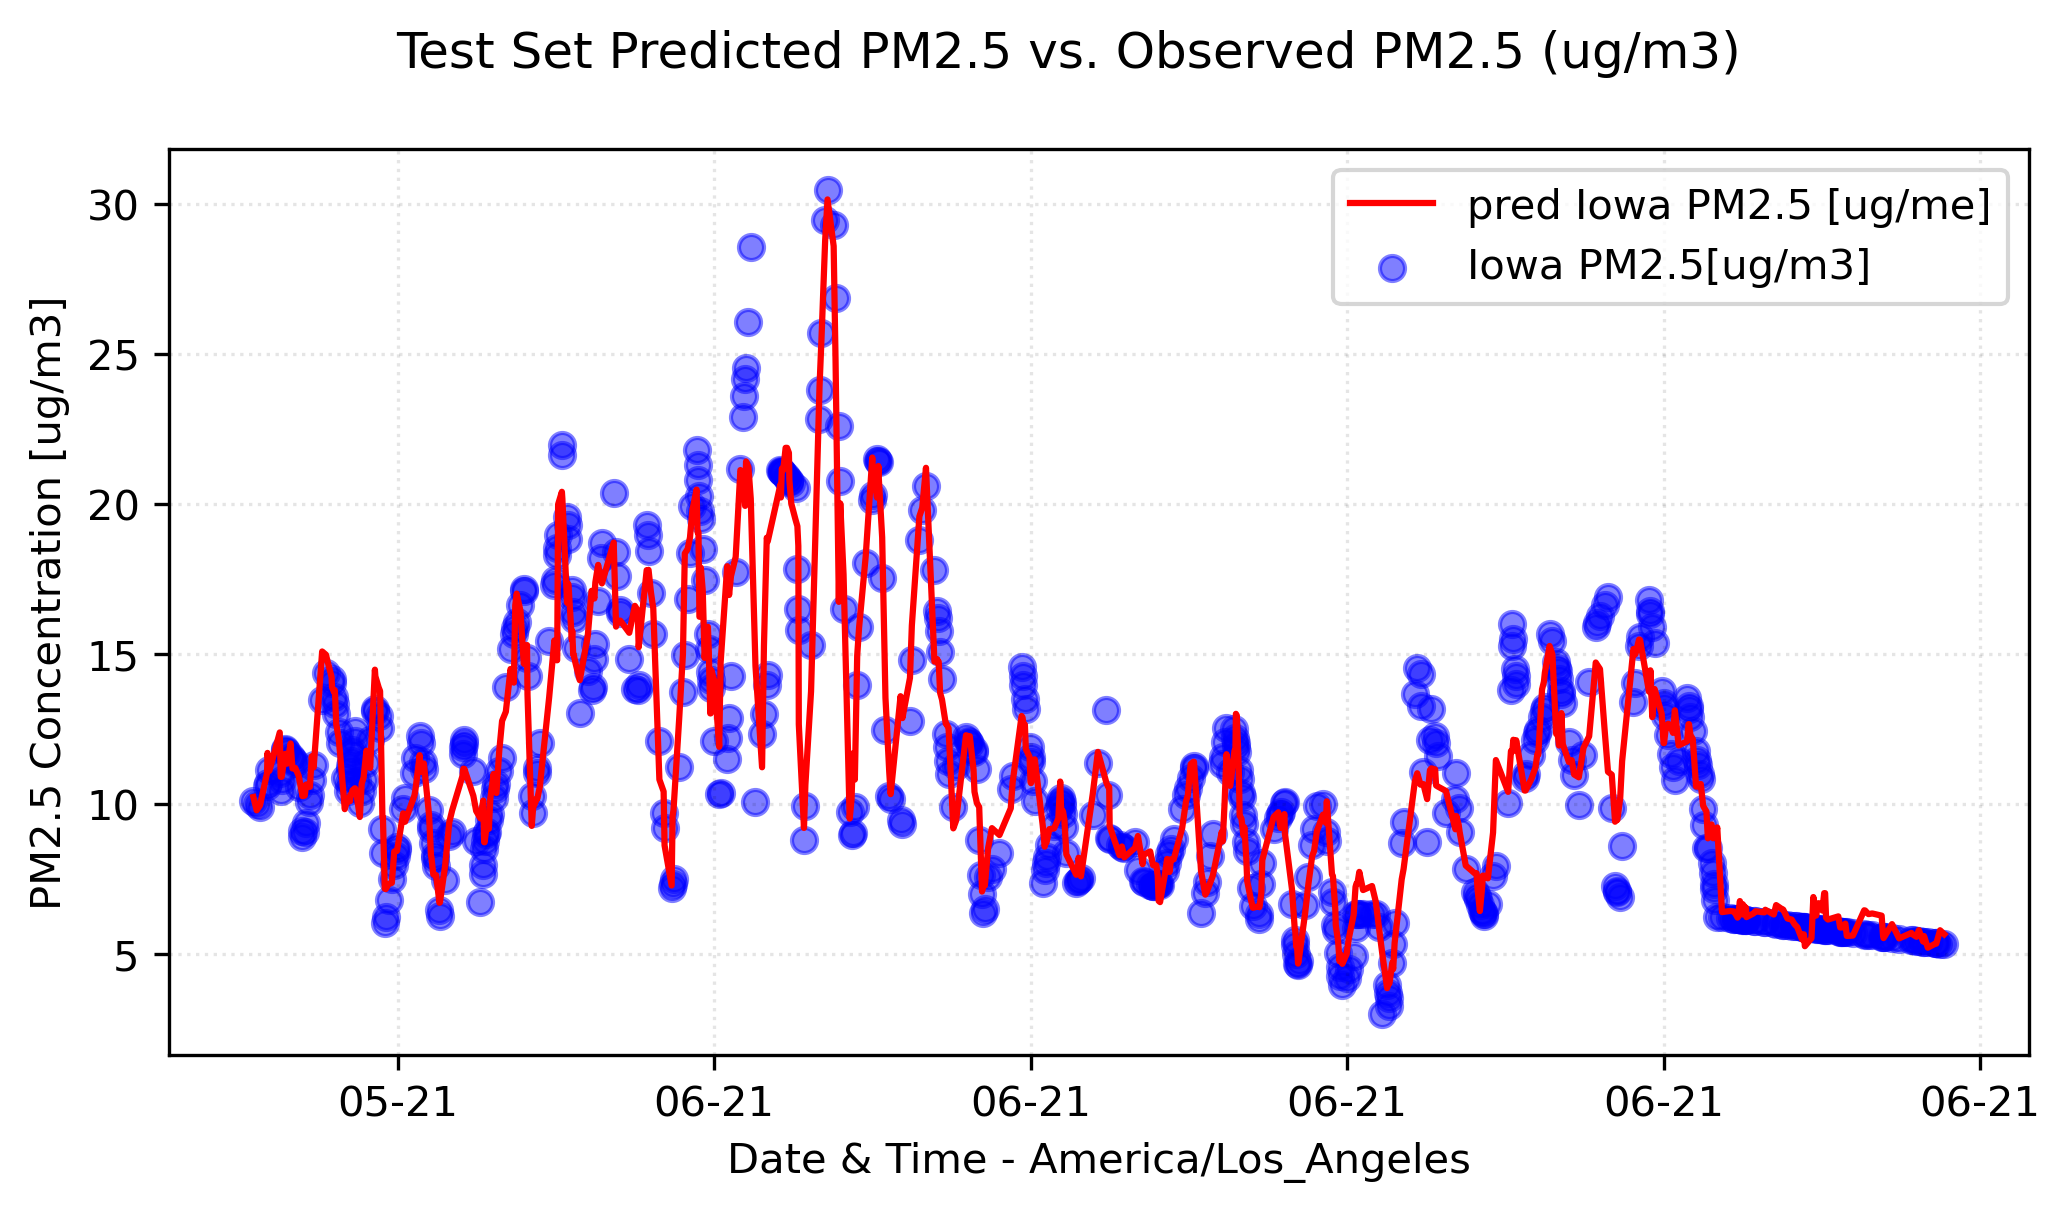

In [19]:
valid_fig, valid_ax = plt.subplots(dpi=300, figsize=(8, 4))
valid_ax.plot(
    iowa_test.loc[:, 'datetime-America/Los_Angeles'],
    iowa_test.loc[:, 'pred Iowa PM2.5 [ug/m3]'],
    color='red',
    label='pred Iowa PM2.5 [ug/me]'
)
valid_ax.scatter(
    iowa_test.loc[:, 'datetime-America/Los_Angeles'],
    iowa_test.loc[:, 'Iowa PM2.5 [ug/m3]'],
    alpha=0.5,
    color='blue',
    label='Iowa PM2.5[ug/m3]'
)
valid_ax.set_ylabel('PM2.5 Concentration [ug/m3]')
valid_ax.set_xlabel('Date & Time - America/Los_Angeles')
valid_ax.xaxis.set_major_locator(mdates.WeekdayLocator(byweekday=1))
valid_ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))
valid_ax.grid(axis='both', alpha=0.1, color='black', linestyle=':')
valid_fig.suptitle('Test Set Predicted PM2.5 vs. Observed PM2.5 (ug/m3)')
valid_ax.legend()
if SAVE_FIGURES:
    valid_fig.savefig('../graphs/traffic_density/Iowa_Test_Evaluation.png', dpi=300)

***
# __Partial Dependence__
***

In [20]:
print(dtk.df_getColNames(iowa_train_x))
iowa_train_x

['year', 'month', 'day', 'dayofweek_Sunday', 'dayofweek_Monday', 'dayofweek_Tuesday', 'dayofweek_Wednesday', 'dayofweek_Thursday', 'dayofweek_Friday', 'dayofweek_Saturday', 'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'PM2.5 Background [ug/m3]', 'Density Local 1 (#Vehicles/mile)', 'Density Local 2 (#Vehicles/mile)', 'Density Local 9 (#Vehicles/mile)', 'Density Local 10 (#Vehicles/mile)', 'Density Fwy 1 (#Vehicles/mile)', 'Density Fwy 2 (#Vehicles/mile)']


year  month  day  dayofweek_Sunday  \
datetime-America/Los_Angeles                                       
2021-05-21 12:45:00-07:00     2021      5   21                 0   
2021-05-21 13:00:00-07:00     2021      5   21                 0   
2021-05-21 13:15:00-07:00     2021      5   21                 0   
2021-05-21 13:30:00-07:00     2021      5   21                 0   
2021-05-21 13:45:00-07:00     2021      5   21                 0   
...                            ...    ...  ...               ...   
2021-06-27 21:00:00-07:00     2021      6   27                 1   
2021-06-27 21:30:00-07:00     2021      6   27                 1   
2021-06-27 22:30:00-07:00     2021      6   27                 1   
2021-06-27 23:00:00-07:00     2021      6   27                 1   
2021-06-27 23:30:00-07:00     2021      6   27                 1   

                              dayofweek_Monday  dayofweek_Tuesday  \
datetime-America/Los_Angeles                                        
2021-05-21 12:45:00-07:00                    0                  0   
2021-05-21 13:00:00-07:00                    0                  0   
2021-05-21 13:15:00-07:00                    0                  0   
2021-05-21 13:30:00-07:00                    0                  0   
2021-05-21 13:45:00-07:00                    0                  0   
...                                        ...                ...   
2021-06-27 21:00:00-07:00                    0                  0   
2021-06-27 21:30:00-07:00                    0                  0   
2021-06-27 22:30:00-07:00                    0                  0   
2021-06-27 23:00:00-07:00                    0                  0   
2021-06-27 23:30:00-07:00                    0                  0   

                              dayofweek_Wednesday  dayofweek_Thursday  \
datetime-America/Los_Angeles                                            
2021-05-21 12:45:00-07:00                       0                   0   
2021-05-21 13:00:00-07:00                       0                   0   
2021-05-21 13:15:00-07:00                       0                   0   
2021-05-21 13:30:00-07:00                       0                   0   
2021-05-21 13:45:00-07:00                       0                   0   
...                                           ...                 ...   
2021-06-27 21:00:00-07:00                       0                   0   
2021-06-27 21:30:00-07:00                       0                   0   
2021-06-27 22:30:00-07:00                       0                   0   
2021-06-27 23:00:00-07:00                       0                   0   
2021-06-27 23:30:00-07:00                       0                   0   

                              dayofweek_Friday  dayofweek_Saturday   temp  \
datetime-America/Los_Angeles                                                
2021-05-21 12:45:00-07:00                    1                   0  19.91   
2021-05-21 13:00:00-07:00                    1                   0  21.14   
2021-05-21 13:15:00-07:00                    1                   0  21.14   
2021-05-21 13:30:00-07:00                    1                   0  21.14   
2021-05-21 13:45:00-07:00                    1                   0  21.14   
...                                        ...                 ...    ...   
2021-06-27 21:00:00-07:00                    0                   0  25.48   
2021-06-27 21:30:00-07:00                    0                   0  25.48   
2021-06-27 22:30:00-07:00                    0                   0  24.69   
2021-06-27 23:00:00-07:00                    0                   0  23.93   
2021-06-27 23:30:00-07:00                    0                   0  23.93   

                              pressure  humidity  wind_speed  wind_deg  \
datetime-America/Los_Angeles                                             
2021-05-21 12:45:00-07:00         1015        30        2.68       260   
2021-05-21 13:00:00-07:00         1014        26        3.13       306   

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  22 | elapsed:   13.5s finished


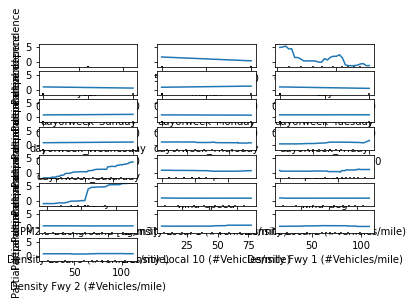

In [21]:
display = PartialDependenceDisplay.from_estimator(
    gbt_model_loo,
    X=iowa_train_x,
    features=nLoop(dtk.df_getColNames(iowa_train_x)),
    feature_names=dtk.df_getColNames(iowa_train_x),
    verbose=True,
    n_jobs=PARALLEL_CORES,
    method='auto',
    kind='average',
    random_state=RANDOM_STATE,
    grid_resolution=150,
    subsample=0.1
)

In [22]:
partial_fig = []
partial_ax = []
for n in nLoop(dtk.df_getColNames(iowa_train_x)):
    fig, ax = plt.subplots(dpi=300)
    plt.close(fig)
    partial_fig.append(fig)
    partial_ax.append(ax)
display.plot(ax=partial_ax)

In [23]:

full_partial_fig, full_partial_ax = plt.subplots(nrows=11, ncols=2, dpi=300, figsize=(22, 44))
display.plot(ax=full_partial_ax)


def activate_grid(x):
    x.grid(linestyle=':')


activate_grid_v = np.vectorize(activate_grid)
activate_grid_v(full_partial_ax)
full_partial_fig.savefig('../graphs/traffic_density/full_partial_dependence.png', dpi=300, facecolor='white',
                         edgecolor='azure')
full_partial_fig

In [24]:
partial_feats = dtk.df_getColNames(iowa_train_x)
feat_filenames = ['year', 'month', 'day', 'dayofweek_01_Sunday', 'dayofweek_02_Monday', 'dayofweek_03_Tuesday',
                  'dayofweek_04_Wednesday', 'dayofweek_05_Thursday', 'dayofweek_06_Friday', 'dayofweek_07_Saturday',
                  'temp', 'pressure', 'humidity', 'wind_speed', 'wind_deg', 'background_pm25', 'density_local1',
                  'density_local2', 'density_local9', 'density_local10', 'density_fwy1', 'density_fwy2']
for i in nLoop(partial_fig):
    partial_fig[i].suptitle(f'Partial Dependence - {partial_feats[i]}')
    partial_ax[i].grid(linestyle=':')
    if SAVE_FIGURES:
        partial_fig[i].savefig(
            f'../graphs/traffic_density/partial_dependence/partial_dependence_{feat_filenames[i]}.png', dpi=300,
            facecolor='white', edgecolor='azure')